# Denoising scRNAseq

In this tutorial, we will walk through the steps for denoising mRNA counts in species-mixing data.   

In this experiment, an equal number of human HEK293T cells and mouse NIH3T3 cells were pooled and sequenced, transcripts from the other organism were unambiguously ambient contamination. The original dataset is downloaded from 10x genomics [dataset](https://www.10xgenomics.com/resources/datasets/20-k-1-1-mixture-of-human-hek-293-t-and-mouse-nih-3-t-3-cells-3-ht-v-3-1-3-1-high-6-1-0), and cell annotation file is available at  [scAR-reproducibility/data](https://github.com/CaibinSh/scAR-reproducibility/tree/main/data)

<div class="alert alert-info">

Note

To run this notebook on your device, you need to install [![scAR](https://img.shields.io/badge/install-scar-brightgreen)](https://scar-tutorials.readthedocs.io/en/latest/Installation.html). 

Alternatively, you can also run this notebook on Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Novartis/scAR/blob/main/docs/tutorials/scAR_tutorial_denoising_scRNAseq.ipynb)

</div>

In [ ]:
# Run this cell to install scar in Colab
# Skip this cell if running on your own device

%pip install scanpy
%pip install git+https://github.com/Novartis/scAR.git
%pip install matplotlib==3.1.3  # Specify this matplotlib version to avoid errors

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scar import model, setup_anndata

import warnings
warnings.simplefilter("ignore")

## Download data

The raw and filtered count matrices can be downloaded from 10x Dataset.

### The raw data

cellranger output: raw_feature_bc_matrix

In [2]:
hgmm_20k_raw = sc.read_10x_h5(filename='20k_hgmm_3p_HT_nextgem_Chromium_X_raw_feature_bc_matrix.h5ad',
                                 backup_url='https://cf.10xgenomics.com/samples/cell-exp/6.1.0/20k_hgmm_3p_HT_nextgem_Chromium_X/20k_hgmm_3p_HT_nextgem_Chromium_X_raw_feature_bc_matrix.h5');
hgmm_20k_raw.var_names_make_unique();

### The filtered data

cellranger output: filtered_feature_bc_matrix

In [3]:
hgmm_20k = sc.read_10x_h5(filename='20k_hgmm_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.h5ad',
                             backup_url='https://cf.10xgenomics.com/samples/cell-exp/6.1.0/20k_hgmm_3p_HT_nextgem_Chromium_X/20k_hgmm_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.h5');
hgmm_20k.var_names_make_unique();

### Annotation and filtering

We annotated cells by their cell species and provided the annotation file

In [4]:
!git clone https://github.com/CaibinSh/scAR-reproducibility.git

hgmm_20k_anno = pd.read_csv('scAR-reproducibility/data/20k_hgmm_cell_annotation.csv', index_col=0) 
hgmm_20k.obs=hgmm_20k.obs.join(hgmm_20k_anno[['species']])

fatal: destination path 'scAR-reproducibility' already exists and is not an empty directory.


Gene and cell filtering

In [5]:
sc.pp.filter_genes(hgmm_20k, min_counts=200);
sc.pp.filter_genes(hgmm_20k, max_counts=6000);
sc.pp.filter_cells(hgmm_20k, min_genes=200);

Calculate number of human and mouse transcripts

In [6]:
hgmm_20k.obs['human gene counts'] = hgmm_20k[:, hgmm_20k.var['genome']=="GRCh38"].X.sum(axis=1).A1
hgmm_20k.obs['mouse gene counts'] = hgmm_20k[:, hgmm_20k.var['genome']=="mm10"].X.sum(axis=1).A1

In [7]:
hgmm_20k

AnnData object with n_obs × n_vars = 16292 × 16586
    obs: 'species', 'n_genes', 'human gene counts', 'mouse gene counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'

## Estimate ambient profile

See details in [calculating ambient profile](https://scar-tutorials.readthedocs.io/en/latest/tutorials/scAR_tutorial_ambient_profile.html)

2023-05-01 18:40:23|INFO|setup_anndata|Randomly sample 199666 droplets from 199666 droplets.
2023-05-01 18:40:23|INFO|setup_anndata|Estimating ambient profile for ['Gene Expression']...
2023-05-01 18:40:49|INFO|setup_anndata|Iteration: 1
2023-05-01 18:41:13|INFO|setup_anndata|Iteration: 2
2023-05-01 18:41:38|INFO|setup_anndata|Iteration: 3
2023-05-01 18:41:38|INFO|setup_anndata|Estimated ambient profile for Gene Expression saved in adata.uns
2023-05-01 18:41:38|INFO|setup_anndata|Estimated ambient profile for all features saved in adata.uns


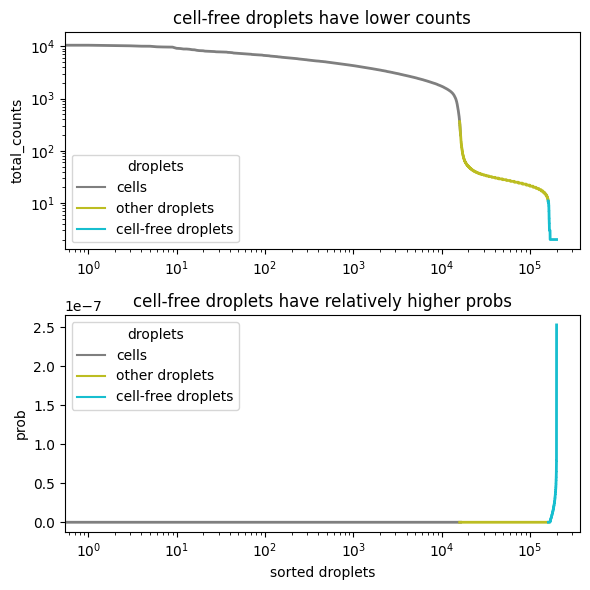

In [8]:
setup_anndata(
    adata = hgmm_20k,
    raw_adata = hgmm_20k_raw,
    prob = 0.995,
    kneeplot = True
)

In [9]:
hgmm_20k.uns["ambient_profile_Gene Expression"].head()

,ambient_profile_Gene Expression
GRCh38_AL627309.5,0.000000
GRCh38_LINC01128,0.000127
GRCh38_LINC00115,0.000000
GRCh38_FAM41C,0.000010
GRCh38_AL645608.2,0.000010


## Training

<div class="alert alert-info">

Note

For this specific case, it is necessary to set a large sparsity parameter as the data is highly sparse for the following reasons:   
    1) the presence of low-coverage transcripts due to the lack of filtering;  
    2) the inclusion of both human and mouse transcripts in the mRNA matrix resulting in extra zero counts. 

However, in the case of data with only highly variable genes, a smaller sparsity parameter is recommended to avoid overcorrection.

</div>

In [10]:
hgmm_20k_scar = model(raw_count=hgmm_20k, # In the case of Anndata object, scar will automatically use the estimated ambient_profile present in adata.uns.
                      ambient_profile=hgmm_20k.uns['ambient_profile_Gene Expression'],
                      feature_type='mRNA',
                      sparsity=1,
                      device='cuda' # Both cpu and cuda are supported.
                     )

hgmm_20k_scar.train(epochs=200,
                    batch_size=64,
                    verbose=True
                   )

# After training, we can infer the native true signal
hgmm_20k_scar.inference(batch_size=256)  # by defaut, batch_size = None, set a batch_size if getting a memory issue

2023-05-01 18:41:40|INFO|model|cuda will be used.
2023-05-01 18:41:47|INFO|VAE|Running VAE using the following param set:
2023-05-01 18:41:47|INFO|VAE|...denoised count type: mRNA
2023-05-01 18:41:47|INFO|VAE|...count model: binomial
2023-05-01 18:41:47|INFO|VAE|...num_input_feature: 16586
2023-05-01 18:41:47|INFO|VAE|...NN_layer1: 150
2023-05-01 18:41:47|INFO|VAE|...NN_layer2: 100
2023-05-01 18:41:47|INFO|VAE|...latent_space: 15
2023-05-01 18:41:47|INFO|VAE|...dropout_prob: 0.00
2023-05-01 18:41:47|INFO|VAE|...expected data sparsity: 1.00
2023-05-01 18:41:47|INFO|model|kld_weight: 1.00e-05
2023-05-01 18:41:47|INFO|model|learning rate: 1.00e-03
2023-05-01 18:41:47|INFO|model|lr_step_size: 5
2023-05-01 18:41:47|INFO|model|lr_gamma: 0.97


Training: 100%|██████████| 200/200 [08:12<00:00,  2.46s/it, Loss=4.7369e+03]


The denoised counts are saved in `hgmm_20k_scar.native_counts` and can be used for downstream analysis.

In [11]:
denoised_count = pd.DataFrame(hgmm_20k_scar.native_counts, index=hgmm_20k.obs_names, columns=hgmm_20k.var_names)
denoised_count.head()

,GRCh38_AL627309.5,GRCh38_LINC01128,GRCh38_LINC00115,GRCh38_FAM41C,GRCh38_AL645608.2,GRCh38_LINC02593,GRCh38_SAMD11,GRCh38_KLHL17,GRCh38_AL645608.7,GRCh38_ISG15,...,mm10___Gm21887,mm10___Kdm5d,mm10___Eif2s3y,mm10___Uty,mm10___Ddx3y,mm10___AC133103.1,mm10___AC168977.1,mm10___CAAA01118383.1,mm10___Spry3,mm10___Tmlhe
AAACCCAAGAGCCGAT-1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGCGTTCCG-1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGTGCGTCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
AAACCCACAAACTGCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCACAATACCTG-1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Visualization

Calculate number of human and mouse transcripts before denoising

In [12]:
raw_counts_df = hgmm_20k.obs[['human gene counts', 'mouse gene counts']].astype(int)
raw_counts_df['log2(human gene counts+1)'] = np.log2(raw_counts_df['human gene counts']+1)
raw_counts_df['log2(mouse gene counts+1)'] = np.log2(raw_counts_df['mouse gene counts']+1)
raw_counts_df = raw_counts_df.join(hgmm_20k.obs[['species']])

visualization of raw counts

<Figure size 600x600 with 0 Axes>

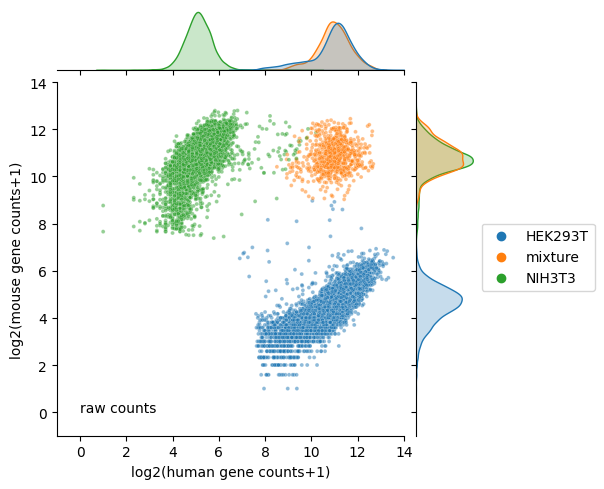

In [13]:
plt.figure(figsize=(4, 4), dpi=150)

ax = sns.jointplot(data=raw_counts_df,
                   x="log2(human gene counts+1)",
                   y="log2(mouse gene counts+1)",
                   hue='species',
                   hue_order=['HEK293T', 'mixture', 'NIH3T3'],
                   s=8,
                   alpha=0.5,
                   legend=True,
                   height=5,
                   marginal_kws={'common_norm':False})
ax.ax_joint.text(0, 0, 'raw counts')
ax.ax_joint.set_xlim(-1, 14)
ax.ax_joint.set_ylim(-1, 14)
ax.ax_joint.legend(bbox_to_anchor=(1.55, 0.6), borderaxespad=0);

Calculate number of human and mouse transcripts after denoising

In [14]:
denoised_count['human gene counts'] = denoised_count.loc[:,denoised_count.columns.str.startswith('GRCh38_')].sum(axis=1)
denoised_count['mouse gene counts'] = denoised_count.loc[:,denoised_count.columns.str.startswith('mm10_')].sum(axis=1)
denoised_count['species'] = raw_counts_df['species']
denoised_count['log2(human gene counts+1)'] = np.log2(denoised_count['human gene counts']+1)
denoised_count['log2(mouse gene counts+1)'] = np.log2(denoised_count['mouse gene counts']+1)

visualization of denoised counts

<Figure size 600x600 with 0 Axes>

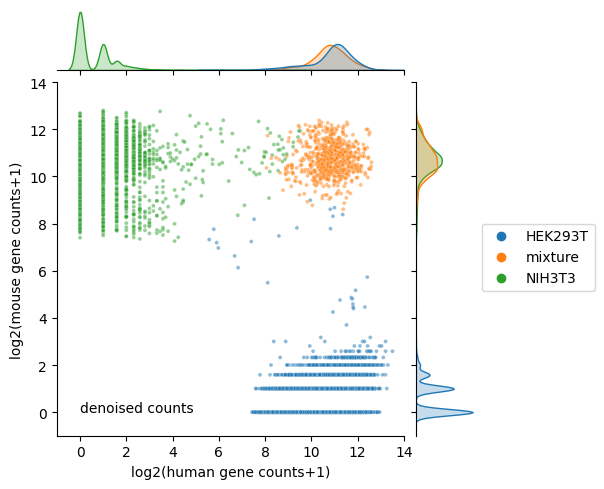

In [15]:
plt.figure(figsize=(4, 4), dpi=150);

ax = sns.jointplot(data=denoised_count,
                   x="log2(human gene counts+1)",
                   y="log2(mouse gene counts+1)",
                   hue='species',
                   hue_order=['HEK293T', 'mixture', 'NIH3T3'],
                   s=8,
                   alpha=0.5,
                   legend=True,
                   height=5,
                   marginal_kws={'common_norm':False});
ax.ax_joint.text(0, 0, 'denoised counts')
ax.ax_joint.set_xlim(-1, 14)
ax.ax_joint.set_ylim(-1, 14)
ax.ax_joint.legend(bbox_to_anchor=(1.55, 0.6), borderaxespad=0);